In [8]:
!export CUDA_VISIBLE_DEVICES=0

%cd /data/codes/apa/train/
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

import pickle
import json
import re
import os

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch

from src.utils.train import (
    load_data,
    to_device,
    validate
)

from src.dataset import PrepDataset
from src.model import PrepModel

/data/codes/apa/train


In [9]:
ckpt_dir = '/data/codes/apa/train/exp/dev'
train_dir = "/data/codes/apa/train/data/feats/train/train-data-type-9-filtered/"
test_dir = "/data/codes/apa/train/data/feats/test/test-data-type-9-filtered/"

max_length=128
relative2id_path="/data/codes/apa/train/exp/dicts/relative2id.json"
phone2id_path="/data/codes/apa/train/exp/dicts/phone_dict.json"

ids, phone_ids_path, word_ids_path, \
    phone_scores_path, word_scores_path, sentence_scores_path, fluency_score_path, intonation_score_path, \
    durations_path, gops_path, relative_positions_path, wavlm_features_path = load_data(train_dir)

trainset = PrepDataset(
    ids=ids, 
    phone_ids_path=phone_ids_path, 
    word_ids_path=word_ids_path, 
    phone_scores_path=phone_scores_path, 
    word_scores_path=word_scores_path, 
    sentence_scores_path=sentence_scores_path, 
    fluency_score_path=fluency_score_path,
    intonation_scores_path=intonation_score_path,
    durations_path=durations_path, 
    gops_path=gops_path, 
    relative_positions_path=relative_positions_path, 
    wavlm_features_path=wavlm_features_path,
    relative2id_path=relative2id_path, 
    phone2id_path=phone2id_path,
    max_length=max_length,

)

trainloader = DataLoader(
    trainset, 
    batch_size=8, 
    num_workers=1,
    shuffle=True, 
    drop_last=False, 
    pin_memory=True
)

ids, phone_ids_path, word_ids_path, \
    phone_scores_path, word_scores_path, sentence_scores_path, fluency_score_path, intonation_score_path, \
    durations_path, gops_path, relative_positions_path, wavlm_features_path = load_data(test_dir)

testset = PrepDataset(
    ids=ids, 
    phone_ids_path=phone_ids_path, 
    word_ids_path=word_ids_path, 
    phone_scores_path=phone_scores_path, 
    word_scores_path=word_scores_path, 
    sentence_scores_path=sentence_scores_path, 
    fluency_score_path=fluency_score_path,
    intonation_scores_path=intonation_score_path,
    durations_path=durations_path, 
    gops_path=gops_path, 
    relative_positions_path=relative_positions_path, 
    wavlm_features_path=wavlm_features_path,
    relative2id_path=relative2id_path, 
    phone2id_path=phone2id_path,
    max_length=max_length,

)

testloader = DataLoader(
    testset, 
    num_workers=1,
    batch_size=64, 
    shuffle=False, 
    drop_last=True, 
)

In [10]:
embed_dim=32
num_heads=1
depth=3
input_dim=855
num_phone=44
max_length=256
dropout=0.1

lr=5e-4
weight_decay=5e-7
betas=(0.95, 0.999)

device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu")

gopt_model = PrepModel(
    embed_dim=embed_dim, 
    num_heads=num_heads, 
    depth=depth, 
    input_dim=input_dim, 
    max_length=max_length, 
    num_phone=num_phone, 
    dropout=dropout).to(device)

trainables = [p for p in gopt_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(
    trainables, lr, 
    weight_decay=weight_decay, 
    betas=betas
)

loss_fn = nn.MSELoss()

In [11]:
ckpt_path = '/data/codes/apa/train/exp/pre-training/ckpts-eph=25-mse=0.08839999884366989/model.pt'
state_dict = torch.load(ckpt_path, map_location="cpu")

gopt_model.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
# params_to_train = [
#     "utt_encoders",
#     "utt_addi",
#     "utt_acc_head",
#     "utt_int_head",
#     "utt_flu_head"
# ]

# params_to_train = set(params_to_train)
# for name, param in gopt_model.named_parameters():
#     name = name.split(".")[0]
#     param.requires_grad = True  if name in params_to_train  else False

In [13]:
def calculate_losses(
        phone_preds, phone_labels, word_preds, word_labels, 
        utterance_preds, utterance_labels, fluency_preds, fluency_labels,
        intonation_preds, intonation_labels):
    
    # phone level
    mask = phone_labels >=0
    phone_preds = phone_preds.squeeze(2) * mask
    phone_labels = phone_labels * mask
    
    loss_phn = loss_fn(phone_preds, phone_labels)
    loss_phn = loss_phn * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)

    # utterance level
    loss_utt = loss_fn(utterance_preds.squeeze(1) ,utterance_labels)

    loss_utt_flu = loss_fn(fluency_preds.squeeze(1) ,fluency_labels)
    loss_utt_int = loss_fn(intonation_preds.squeeze(1) ,intonation_labels)

    # word level
    mask = word_labels >= 0      
    word_preds = word_preds.squeeze(2) * mask
    word_labels = word_labels * mask
    
    loss_word = loss_fn(word_preds, word_labels)
    loss_word = loss_word * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)

    return loss_phn, loss_utt, loss_word, loss_utt_flu, loss_utt_int

Training: 100%|██████████| 2057/2057 [00:11<00:00, 179.11it/s, loss=0.293, loss_phn=0.169, loss_utt=0.0144, loss_word=0.092, lr=0.0005]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.89      0.92    137433
         1.0       0.20      0.50      0.29     11034
         2.0       0.80      0.41      0.54     16688

    accuracy                           0.81    165155
   macro avg       0.65      0.60      0.58    165155
weighted avg       0.88      0.81      0.84    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=0-mse=0.14790000021457672
### Validation result (epoch=0)
  Phone level (ACC): MSE=0.148  MAE=0.222  PCC=0.737 
   Word level (ACC): MSE=0.103  MAE=0.238  PCC=0.745 
    Utt level (ACC): MSE=0.020  MAE=0.119  PCC=0.836 
    Utt level (Intonation):  MSE=0.053  MAE=0.194  PCC=0.558
    Utt level (Fluency):  MSE=0.055  MAE=0.188  PCC=0.265



Training: 100%|██████████| 2057/2057 [00:11<00:00, 174.55it/s, loss=0.254, loss_phn=0.123, loss_utt=0.0135, loss_word=0.0995, lr=0.0005]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.92    137433
         1.0       0.21      0.50      0.29     11034
         2.0       0.83      0.40      0.54     16688

    accuracy                           0.82    165155
   macro avg       0.66      0.60      0.58    165155
weighted avg       0.88      0.82      0.84    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=1-mse=0.14079999923706055
### Validation result (epoch=1)
  Phone level (ACC): MSE=0.141  MAE=0.214  PCC=0.752 
   Word level (ACC): MSE=0.098  MAE=0.221  PCC=0.757 
    Utt level (ACC): MSE=0.020  MAE=0.117  PCC=0.848 
    Utt level (Intonation):  MSE=0.045  MAE=0.165  PCC=0.662
    Utt level (Fluency):  MSE=0.048  MAE=0.166  PCC=0.411



Training: 100%|██████████| 2057/2057 [00:11<00:00, 176.91it/s, loss=0.223, loss_phn=0.113, loss_utt=0.0297, loss_word=0.0877, lr=0.0005]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.89      0.92    137433
         1.0       0.21      0.50      0.30     11034
         2.0       0.81      0.45      0.58     16688

    accuracy                           0.82    165155
   macro avg       0.65      0.62      0.60    165155
weighted avg       0.88      0.82      0.84    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=2-mse=0.13760000467300415
### Validation result (epoch=2)
  Phone level (ACC): MSE=0.138  MAE=0.212  PCC=0.758 
   Word level (ACC): MSE=0.096  MAE=0.222  PCC=0.762 
    Utt level (ACC): MSE=0.018  MAE=0.112  PCC=0.857 
    Utt level (Intonation):  MSE=0.042  MAE=0.160  PCC=0.723
    Utt level (Fluency):  MSE=0.049  MAE=0.160  PCC=0.487



Training: 100%|██████████| 2057/2057 [00:11<00:00, 179.62it/s, loss=0.238, loss_phn=0.136, loss_utt=0.00505, loss_word=0.0627, lr=0.0005] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.92    137433
         1.0       0.21      0.52      0.30     11034
         2.0       0.80      0.48      0.60     16688

    accuracy                           0.82    165155
   macro avg       0.65      0.63      0.60    165155
weighted avg       0.89      0.82      0.84    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=3-mse=0.13539999723434448
### Validation result (epoch=3)
  Phone level (ACC): MSE=0.135  MAE=0.215  PCC=0.763 
   Word level (ACC): MSE=0.094  MAE=0.224  PCC=0.770 
    Utt level (ACC): MSE=0.020  MAE=0.116  PCC=0.846 
    Utt level (Intonation):  MSE=0.044  MAE=0.168  PCC=0.758
    Utt level (Fluency):  MSE=0.042  MAE=0.155  PCC=0.548



Training: 100%|██████████| 2057/2057 [00:11<00:00, 178.80it/s, loss=0.293, loss_phn=0.164, loss_utt=0.00571, loss_word=0.0925, lr=0.0005] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.92    137433
         1.0       0.22      0.49      0.30     11034
         2.0       0.80      0.48      0.60     16688

    accuracy                           0.83    165155
   macro avg       0.66      0.63      0.61    165155
weighted avg       0.89      0.83      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=4-mse=0.13339999318122864
### Validation result (epoch=4)
  Phone level (ACC): MSE=0.133  MAE=0.202  PCC=0.767 
   Word level (ACC): MSE=0.092  MAE=0.212  PCC=0.773 
    Utt level (ACC): MSE=0.017  MAE=0.107  PCC=0.870 
    Utt level (Intonation):  MSE=0.035  MAE=0.137  PCC=0.734
    Utt level (Fluency):  MSE=0.041  MAE=0.155  PCC=0.558



Training: 100%|██████████| 2057/2057 [00:11<00:00, 176.93it/s, loss=0.293, loss_phn=0.156, loss_utt=0.0132, loss_word=0.104, lr=0.0005]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.89      0.92    137433
         1.0       0.21      0.52      0.30     11034
         2.0       0.80      0.50      0.61     16688

    accuracy                           0.82    165155
   macro avg       0.65      0.63      0.61    165155
weighted avg       0.89      0.82      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=5-mse=0.13179999589920044
### Validation result (epoch=5)
  Phone level (ACC): MSE=0.132  MAE=0.208  PCC=0.771 
   Word level (ACC): MSE=0.092  MAE=0.217  PCC=0.774 
    Utt level (ACC): MSE=0.019  MAE=0.112  PCC=0.866 
    Utt level (Intonation):  MSE=0.034  MAE=0.142  PCC=0.743
    Utt level (Fluency):  MSE=0.042  MAE=0.160  PCC=0.536



Training: 100%|██████████| 2057/2057 [00:11<00:00, 174.82it/s, loss=0.285, loss_phn=0.121, loss_utt=0.0252, loss_word=0.0833, lr=0.0004]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.92    137433
         1.0       0.22      0.50      0.30     11034
         2.0       0.80      0.50      0.61     16688

    accuracy                           0.83    165155
   macro avg       0.66      0.63      0.61    165155
weighted avg       0.89      0.83      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=6-mse=0.13050000369548798
### Validation result (epoch=6)
  Phone level (ACC): MSE=0.130  MAE=0.201  PCC=0.773 
   Word level (ACC): MSE=0.090  MAE=0.211  PCC=0.778 
    Utt level (ACC): MSE=0.017  MAE=0.107  PCC=0.868 
    Utt level (Intonation):  MSE=0.038  MAE=0.149  PCC=0.749
    Utt level (Fluency):  MSE=0.041  MAE=0.152  PCC=0.558



Training: 100%|██████████| 2057/2057 [00:11<00:00, 176.85it/s, loss=0.287, loss_phn=0.134, loss_utt=0.00272, loss_word=0.123, lr=0.0004]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.92    137433
         1.0       0.22      0.51      0.31     11034
         2.0       0.81      0.48      0.60     16688

    accuracy                           0.83    165155
   macro avg       0.66      0.63      0.61    165155
weighted avg       0.89      0.83      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=7-mse=0.12970000505447388
### Validation result (epoch=7)
  Phone level (ACC): MSE=0.130  MAE=0.200  PCC=0.774 
   Word level (ACC): MSE=0.090  MAE=0.214  PCC=0.777 
    Utt level (ACC): MSE=0.017  MAE=0.109  PCC=0.876 
    Utt level (Intonation):  MSE=0.035  MAE=0.138  PCC=0.741
    Utt level (Fluency):  MSE=0.039  MAE=0.150  PCC=0.578



Training: 100%|██████████| 2057/2057 [00:11<00:00, 175.80it/s, loss=0.194, loss_phn=0.0959, loss_utt=0.00245, loss_word=0.0654, lr=0.0004]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.92    137433
         1.0       0.22      0.51      0.31     11034
         2.0       0.80      0.49      0.61     16688

    accuracy                           0.83    165155
   macro avg       0.66      0.63      0.62    165155
weighted avg       0.89      0.83      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=8-mse=0.12880000472068787
### Validation result (epoch=8)
  Phone level (ACC): MSE=0.129  MAE=0.202  PCC=0.776 
   Word level (ACC): MSE=0.089  MAE=0.212  PCC=0.779 
    Utt level (ACC): MSE=0.018  MAE=0.110  PCC=0.856 
    Utt level (Intonation):  MSE=0.040  MAE=0.154  PCC=0.762
    Utt level (Fluency):  MSE=0.043  MAE=0.151  PCC=0.575



Training: 100%|██████████| 2057/2057 [00:11<00:00, 177.56it/s, loss=0.297, loss_phn=0.134, loss_utt=0.0311, loss_word=0.104, lr=0.00032]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93    137433
         1.0       0.23      0.48      0.31     11034
         2.0       0.80      0.50      0.62     16688

    accuracy                           0.84    165155
   macro avg       0.66      0.63      0.62    165155
weighted avg       0.89      0.84      0.86    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=9-mse=0.12860000133514404
### Validation result (epoch=9)
  Phone level (ACC): MSE=0.129  MAE=0.196  PCC=0.776 
   Word level (ACC): MSE=0.089  MAE=0.206  PCC=0.781 
    Utt level (ACC): MSE=0.017  MAE=0.105  PCC=0.864 
    Utt level (Intonation):  MSE=0.034  MAE=0.133  PCC=0.745
    Utt level (Fluency):  MSE=0.041  MAE=0.155  PCC=0.569



Training: 100%|██████████| 2057/2057 [00:11<00:00, 175.73it/s, loss=0.251, loss_phn=0.149, loss_utt=0.0105, loss_word=0.0912, lr=0.00032]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.93    137433
         1.0       0.22      0.49      0.31     11034
         2.0       0.80      0.50      0.62     16688

    accuracy                           0.83    165155
   macro avg       0.66      0.63      0.62    165155
weighted avg       0.89      0.83      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=10-mse=0.12839999794960022
### Validation result (epoch=10)
  Phone level (ACC): MSE=0.128  MAE=0.199  PCC=0.777 
   Word level (ACC): MSE=0.089  MAE=0.206  PCC=0.779 
    Utt level (ACC): MSE=0.020  MAE=0.111  PCC=0.841 
    Utt level (Intonation):  MSE=0.036  MAE=0.142  PCC=0.745
    Utt level (Fluency):  MSE=0.039  MAE=0.150  PCC=0.592



Training: 100%|██████████| 2057/2057 [00:11<00:00, 178.82it/s, loss=0.237, loss_phn=0.129, loss_utt=0.00469, loss_word=0.0931, lr=0.00032] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.92    137433
         1.0       0.22      0.50      0.31     11034
         2.0       0.79      0.52      0.63     16688

    accuracy                           0.83    165155
   macro avg       0.66      0.64      0.62    165155
weighted avg       0.89      0.83      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=11-mse=0.1289999932050705
### Validation result (epoch=11)
  Phone level (ACC): MSE=0.129  MAE=0.199  PCC=0.776 
   Word level (ACC): MSE=0.090  MAE=0.211  PCC=0.778 
    Utt level (ACC): MSE=0.019  MAE=0.110  PCC=0.858 
    Utt level (Intonation):  MSE=0.041  MAE=0.162  PCC=0.757
    Utt level (Fluency):  MSE=0.046  MAE=0.159  PCC=0.596



Training: 100%|██████████| 2057/2057 [00:11<00:00, 175.36it/s, loss=0.222, loss_phn=0.114, loss_utt=0.0213, loss_word=0.0607, lr=0.000256]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.93    137433
         1.0       0.22      0.50      0.31     11034
         2.0       0.80      0.50      0.62     16688

    accuracy                           0.83    165155
   macro avg       0.66      0.63      0.62    165155
weighted avg       0.89      0.83      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=12-mse=0.12770000100135803
### Validation result (epoch=12)
  Phone level (ACC): MSE=0.128  MAE=0.197  PCC=0.778 
   Word level (ACC): MSE=0.088  MAE=0.208  PCC=0.781 
    Utt level (ACC): MSE=0.020  MAE=0.113  PCC=0.852 
    Utt level (Intonation):  MSE=0.033  MAE=0.136  PCC=0.764
    Utt level (Fluency):  MSE=0.037  MAE=0.147  PCC=0.609



Training: 100%|██████████| 2057/2057 [00:11<00:00, 174.92it/s, loss=0.231, loss_phn=0.141, loss_utt=0.0192, loss_word=0.0719, lr=0.000256]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.93    137433
         1.0       0.22      0.48      0.31     11034
         2.0       0.79      0.52      0.63     16688

    accuracy                           0.84    165155
   macro avg       0.66      0.63      0.62    165155
weighted avg       0.89      0.84      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=13-mse=0.12849999964237213
### Validation result (epoch=13)
  Phone level (ACC): MSE=0.128  MAE=0.195  PCC=0.777 
   Word level (ACC): MSE=0.089  MAE=0.209  PCC=0.780 
    Utt level (ACC): MSE=0.018  MAE=0.106  PCC=0.860 
    Utt level (Intonation):  MSE=0.033  MAE=0.135  PCC=0.758
    Utt level (Fluency):  MSE=0.038  MAE=0.152  PCC=0.621



Training: 100%|██████████| 2057/2057 [00:11<00:00, 177.12it/s, loss=0.2, loss_phn=0.0968, loss_utt=0.0286, loss_word=0.0681, lr=0.000256]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.93    137433
         1.0       0.24      0.46      0.31     11034
         2.0       0.81      0.49      0.61     16688

    accuracy                           0.85    165155
   macro avg       0.67      0.62      0.62    165155
weighted avg       0.89      0.85      0.86    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=14-mse=0.12870000302791595
### Validation result (epoch=14)
  Phone level (ACC): MSE=0.129  MAE=0.187  PCC=0.778 
   Word level (ACC): MSE=0.090  MAE=0.198  PCC=0.781 
    Utt level (ACC): MSE=0.020  MAE=0.118  PCC=0.862 
    Utt level (Intonation):  MSE=0.035  MAE=0.140  PCC=0.743
    Utt level (Fluency):  MSE=0.037  MAE=0.145  PCC=0.611



Training: 100%|██████████| 2057/2057 [00:11<00:00, 177.62it/s, loss=0.241, loss_phn=0.133, loss_utt=0.0035, loss_word=0.0728, lr=0.000205]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.93    137433
         1.0       0.23      0.49      0.31     11034
         2.0       0.80      0.51      0.62     16688

    accuracy                           0.84    165155
   macro avg       0.66      0.64      0.62    165155
weighted avg       0.89      0.84      0.86    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=15-mse=0.12729999423027039
### Validation result (epoch=15)
  Phone level (ACC): MSE=0.127  MAE=0.194  PCC=0.779 
   Word level (ACC): MSE=0.088  MAE=0.204  PCC=0.782 
    Utt level (ACC): MSE=0.018  MAE=0.109  PCC=0.858 
    Utt level (Intonation):  MSE=0.038  MAE=0.150  PCC=0.746
    Utt level (Fluency):  MSE=0.039  MAE=0.155  PCC=0.599



Training: 100%|██████████| 2057/2057 [00:13<00:00, 155.14it/s, loss=0.185, loss_phn=0.0748, loss_utt=0.015, loss_word=0.068, lr=0.000205]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.93    137433
         1.0       0.23      0.49      0.31     11034
         2.0       0.80      0.52      0.63     16688

    accuracy                           0.84    165155
   macro avg       0.66      0.64      0.62    165155
weighted avg       0.89      0.84      0.86    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=16-mse=0.12710000574588776
### Validation result (epoch=16)
  Phone level (ACC): MSE=0.127  MAE=0.195  PCC=0.779 
   Word level (ACC): MSE=0.088  MAE=0.207  PCC=0.783 
    Utt level (ACC): MSE=0.018  MAE=0.110  PCC=0.854 
    Utt level (Intonation):  MSE=0.033  MAE=0.129  PCC=0.745
    Utt level (Fluency):  MSE=0.040  MAE=0.162  PCC=0.612



Training: 100%|██████████| 2057/2057 [00:11<00:00, 171.52it/s, loss=0.254, loss_phn=0.0958, loss_utt=0.00688, loss_word=0.0567, lr=0.000205]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.93    137433
         1.0       0.22      0.49      0.31     11034
         2.0       0.79      0.53      0.63     16688

    accuracy                           0.84    165155
   macro avg       0.66      0.64      0.62    165155
weighted avg       0.89      0.84      0.85    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=17-mse=0.1274999976158142
### Validation result (epoch=17)
  Phone level (ACC): MSE=0.127  MAE=0.197  PCC=0.779 
   Word level (ACC): MSE=0.088  MAE=0.209  PCC=0.782 
    Utt level (ACC): MSE=0.018  MAE=0.107  PCC=0.865 
    Utt level (Intonation):  MSE=0.039  MAE=0.151  PCC=0.730
    Utt level (Fluency):  MSE=0.040  MAE=0.154  PCC=0.596



Training: 100%|██████████| 2057/2057 [00:11<00:00, 176.96it/s, loss=0.209, loss_phn=0.101, loss_utt=0.0065, loss_word=0.0792, lr=0.000164]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93    137433
         1.0       0.23      0.48      0.31     11034
         2.0       0.80      0.52      0.63     16688

    accuracy                           0.84    165155
   macro avg       0.66      0.64      0.62    165155
weighted avg       0.89      0.84      0.86    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=18-mse=0.12710000574588776
### Validation result (epoch=18)
  Phone level (ACC): MSE=0.127  MAE=0.192  PCC=0.780 
   Word level (ACC): MSE=0.088  MAE=0.203  PCC=0.782 
    Utt level (ACC): MSE=0.018  MAE=0.109  PCC=0.863 
    Utt level (Intonation):  MSE=0.037  MAE=0.146  PCC=0.744
    Utt level (Fluency):  MSE=0.039  MAE=0.150  PCC=0.609



Training: 100%|██████████| 2057/2057 [00:11<00:00, 178.96it/s, loss=0.159, loss_phn=0.0782, loss_utt=0.00479, loss_word=0.0615, lr=0.000164]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93    137433
         1.0       0.23      0.47      0.31     11034
         2.0       0.80      0.52      0.63     16688

    accuracy                           0.84    165155
   macro avg       0.66      0.63      0.62    165155
weighted avg       0.89      0.84      0.86    165155

Save state dict and result to /data/codes/apa/train/exp/dev/ckpts-eph=19-mse=0.12710000574588776
### Validation result (epoch=19)
  Phone level (ACC): MSE=0.127  MAE=0.191  PCC=0.780 
   Word level (ACC): MSE=0.088  MAE=0.203  PCC=0.781 
    Utt level (ACC): MSE=0.018  MAE=0.109  PCC=0.858 
    Utt level (Intonation):  MSE=0.037  MAE=0.142  PCC=0.740
    Utt level (Fluency):  MSE=0.041  MAE=0.154  PCC=0.603



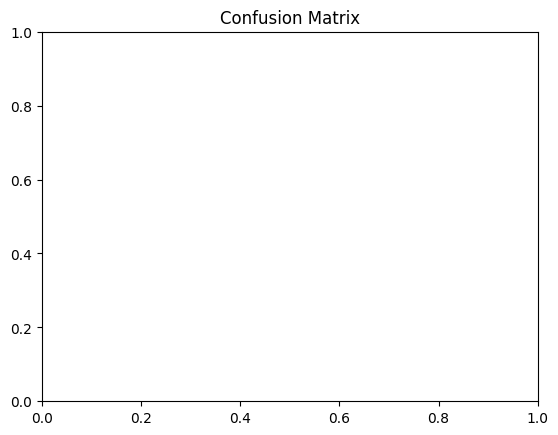

In [14]:
global_step = 0
best_mse = 1e5
num_epoch = 20
phone_weight = 1.0
word_weight = 1.0
utterance_weight = 1.0

cur_lr = lr
for epoch in range(num_epoch):
    if epoch >= 5 and epoch % 3 == 0:
        cur_lr = (4 / 5) * cur_lr 
        for param_group in optimizer.param_groups:
            param_group['lr'] = cur_lr

    gopt_model.train()
    train_tqdm = tqdm(trainloader, "Training")
    for batch in train_tqdm:
        optimizer.zero_grad()

        ids, features, phone_ids, word_ids, relative_positions, \
            phone_labels, word_labels, utterance_labels, \
            fluency_labels, intonation_labels = to_device(batch, device)
        
        utterance_preds, phone_preds, word_preds, flu_preds, int_preds = gopt_model(
            x=features.float(), phn=phone_ids.long(), rel_pos=relative_positions.long())
                
        loss_phn, loss_utt, loss_word, loss_utt_flu, loss_utt_int = calculate_losses(
            phone_preds=phone_preds, 
            phone_labels=phone_labels, 
            word_preds=word_preds, 
            word_labels=word_labels, 
            utterance_preds=utterance_preds, 
            utterance_labels=utterance_labels,
            fluency_preds=flu_preds, 
            fluency_labels=fluency_labels,
            intonation_preds=int_preds,
            intonation_labels=intonation_labels
        )

        loss = phone_weight*loss_phn + word_weight*loss_word + utterance_weight*(loss_utt + loss_utt_flu + loss_utt_int)/3
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gopt_model.parameters(), 1.0)
        
        optimizer.step()
        
        global_step += 1
        train_tqdm.set_postfix(
            lr=cur_lr,
            loss=loss.item(), 
            loss_phn=loss_phn.item(), 
            loss_word=loss_word.item(), 
            loss_utt=loss_utt.item())
    
    valid_result = validate(
        epoch=epoch, 
        optimizer=optimizer,
        gopt_model=gopt_model, 
        testloader=testloader, 
        best_mse=best_mse, 
        ckpt_dir=ckpt_dir,
        device=device)
    
    best_mse = valid_result["best_mse"]
    global_step += 1